## Model_NowTV
## Table of Contents:
* [0. Importing dependencies](#dependencies)
* [1. Setting up of the dataset](#1.0)
    * [1.1 Importing of the dataset](#1.1)
    * [1.2 Splitting of the dataset](#1.2)
* [2. Model Implementation](#2.0)
    * [2.1 Model training](#2.1)


# 0. Importing dependencies  <a class="anchor" id="dependencies"></a>

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor 
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import joblib

# 1. Setting up of the dataset <a class="anchor" id="1.0"></a>

## 1.1 Importing of the dataset <a class="anchor" id="1.1"></a>

In [15]:
# Load the final dataframe
file_path = '/Users/elynyang/Desktop/Final project/dataset/df_final.csv'
df_final = pd.read_csv(file_path)

print(df_final.columns)

Index(['trend_vc', 'yearly_vc', 'weekly_vc', 'trend_i', 'yearly_i', 'weekly_i',
       'trend_ud', 'yearly_ud', 'weekly_ud', 'videoConsumption', 'impression'],
      dtype='object')


## 1.2 Splitting the dataset <a class="anchor" id="1.2"></a>

In [16]:
# Define input features and target outputs
prophet_features = ['weekly_vc', 'weekly_i', 'weekly_ud']
# original_features = ['videoConsumption', 'impression']
targets = ['videoConsumption', 'impression']

all_features = prophet_features + targets  # Include both Prophet features and original data


In [17]:
# Split dataset function
def split_dataset(df):
    idx_train_end = round(0.7 * len(df))
    idx_val_end = round(0.85 * len(df))
    return df.iloc[:idx_train_end], df.iloc[idx_train_end:idx_val_end], df.iloc[idx_val_end:]

df_train, df_val, df_test = split_dataset(df_final)

# 2. Model Implementation <a class="anchor" id="2.0"></a>

## 2.1 Model training <a class="anchor" id="2.1"></a>

In [22]:
def rolling_window_forecast(data, window_size, forecast_horizon, model):
    predictions_vc, predictions_i = [], []
    true_values_vc, true_values_i = [], []

    for start in range(0, len(data) - window_size - forecast_horizon, forecast_horizon):
        end = start + window_size
        X_train = data[start:end]
        y_train_vc = data[start:end, -2]
        y_train_i = data[start:end, -1]

        X_test = data[end:end + forecast_horizon]
        y_test_vc = data[end:end + forecast_horizon, -2]
        y_test_i = data[end:end + forecast_horizon, -1]

        y_train = np.vstack((y_train_vc, y_train_i)).T
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        predictions_vc.extend(y_pred[:, 0])
        predictions_i.extend(y_pred[:, 1])
        true_values_vc.extend(y_test_vc)
        true_values_i.extend(y_test_i)

    return predictions_vc, predictions_i, true_values_vc, true_values_i


In [19]:
def plot_predictions(true_values, predictions, title):
    plt.figure(figsize=(10, 6))
    plt.plot(true_values, label='True Values')
    plt.plot(predictions, label='Predictions', linestyle='--')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [20]:
# Window sizes for rolling window
window_sizes = {
    '1 day': 1440,
    '4 days': 1440 * 4,
    '1 week': 1440 * 7,
}
forecast_horizon = 1440
results = {}
errors = {}
min_rmse = float('inf')
best_window_size = None
best_model = None

Window: 1 day
  Video Consumption - MSE: 295196995.718, RMSE: 17181.298
  Impression - MSE: 66708.031, RMSE: 258.279


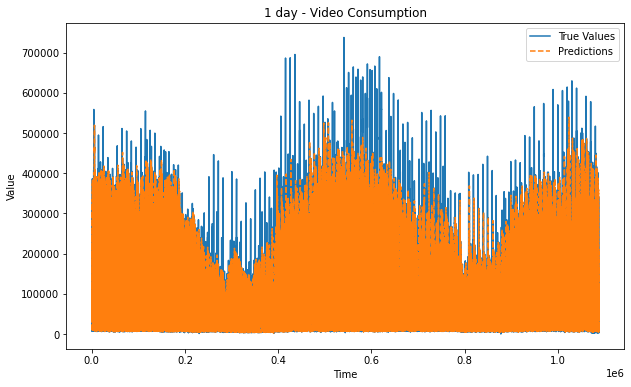

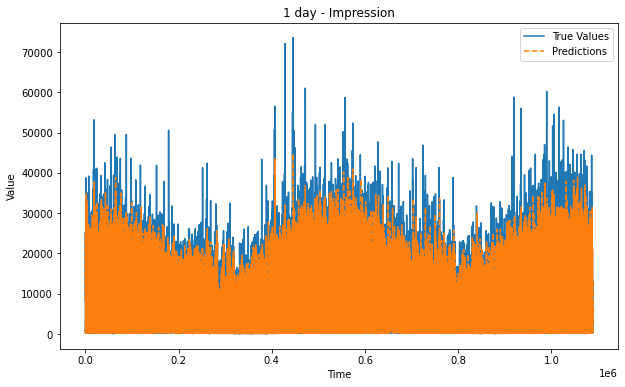

Window: 4 days
  Video Consumption - MSE: 89376177.983, RMSE: 9453.898
  Impression - MSE: 19798.967, RMSE: 140.709


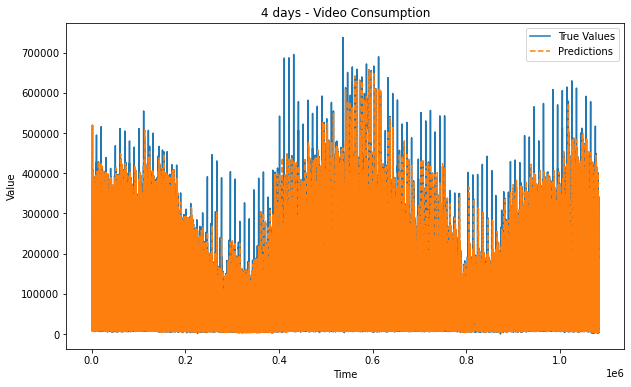

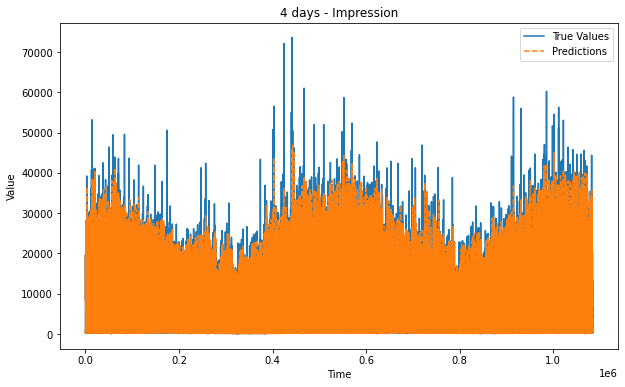

Window: 1 week
  Video Consumption - MSE: 15504633.679, RMSE: 3937.592
  Impression - MSE: 11903.492, RMSE: 109.103


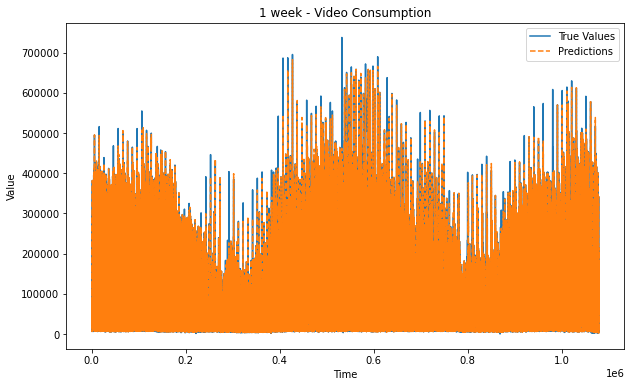

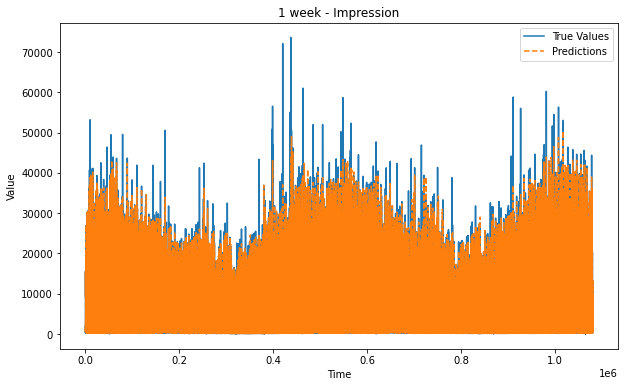

In [23]:
# Evaluate model for each window size
train_data = df_train[all_features].dropna().values

for window_name, window_size in window_sizes.items():
    model = RandomForestRegressor(random_state=42)
    mor = MultiOutputRegressor(model)
    
    predictions_vc, predictions_i, true_values_vc, true_values_i = rolling_window_forecast(train_data, window_size, forecast_horizon, mor)
    
    mse_vc = mean_squared_error(true_values_vc, predictions_vc)
    rmse_vc = sqrt(mse_vc)
    mse_i = mean_squared_error(true_values_i, predictions_i)
    rmse_i = sqrt(mse_i)
    
    if rmse_vc + rmse_i < min_rmse:
        min_rmse = rmse_vc + rmse_i
        best_window_size = window_size
        best_model = mor

    errors[window_name] = {
        'MSE_vc': mse_vc,
        'RMSE_vc': rmse_vc,
        'MSE_i': mse_i,
        'RMSE_i': rmse_i
    }
    
    print(f"Window: {window_name}")
    print(f"  Video Consumption - MSE: {mse_vc:.3f}, RMSE: {rmse_vc:.3f}")
    print(f"  Impression - MSE: {mse_i:.3f}, RMSE: {rmse_i:.3f}")
    
    plot_predictions(true_values_vc, predictions_vc, f'{window_name} - Video Consumption')
    plot_predictions(true_values_i, predictions_i, f'{window_name} - Impression')

In [24]:
# Save the best model 
model_filename = '/Users/elynyang/Desktop/Final project/Code file/rf_rw_add_best_model.pkl'
joblib.dump(best_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to /Users/elynyang/Desktop/Final project/Code file/rf_rw_add_best_model.pkl


In [5]:
# Path to the saved model
model_filename = '/Users/elynyang/Desktop/Final project/Code file/rf_rw_add_best_model.pkl'

# Load the model
best_model = joblib.load(model_filename)

# Print a confirmation message
print(f"Model loaded from {model_filename}")

Model loaded from /Users/elynyang/Desktop/Final project/Code file/rf_rw_add_best_model.pkl


In [6]:
print("\nBest Model Parameters:")
print(best_model.estimators_[0].get_params())


Best Model Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [7]:
print("\nBest Model Features Importance:")
print(best_model.estimators_[0].feature_importances_)


Best Model Features Importance:
[2.15455283e-05 2.89906469e-05 3.23066636e-05 9.99915800e-01
 1.35686005e-06]
